# 套件導入

In [166]:
import pandas as pd 
import numpy as np 
import tejapi
from collections import Counter
import matplotlib.pyplot as plt


# 資料導入

In [123]:
# log in TEJ API
api_key = 'oErfT7UMxWlKH5tv9s2NYcbdbVKWzW'
tejapi.ApiConfig.api_key = api_key
tejapi.ApiConfig.ignoretz = True
tejapi.ApiConfig.api_base="http://10.10.10.66"

In [124]:
gte, lte = '2021-01-01', '2021-12-31'
TR = tejapi.get('TWN/ACSR01A',
                   paginate = True,
                   mdate = {'gte':gte, 'lte':lte},             
                  )

In [185]:
gte, lte = '2020-01-01', '2021-01-01'
ED = tejapi.get('TWN/AXEMPA',
                   paginate = True,
                   mdate = {'gte':gte, 'lte':lte},             
                  )

In [186]:
ED = ED[["coid", "apct", "bpct" ,"cpct", "dpct", "epct", "fpct" , "emp_sum", "emp_age", "emp_yr"]]

In [187]:
gte, lte = '2020-01-01', '2021-01-01'
LAW = tejapi.get('TWN/ACSR20A',
                   paginate = True,
                   mdate = {'gte':gte, 'lte':lte},             
                  )

In [188]:
LAW = pd.DataFrame(data = [Counter(LAW["coid"]).keys(), Counter(LAW["coid"]).values()]).T.rename(columns = {0:"coid", 1:"violate_times"})
LAW


,coid,violate_times
0,000960,2
1,1101,5
2,1102,5
3,1104,1
4,1108,1
...,...,...
14056,CSR-97577492,1
14057,CSR-97601227,1
14058,CSR-97623427,1
14059,CSR-97630102,1


In [189]:
gte, lte = '2021-01-01', '2021-12-31'
TWSE = tejapi.get('TWN/ACSR19A',
                   paginate = True,
                   mdate = {'gte':gte, 'lte':lte},             
                  )

In [190]:
TWSE = TWSE[["coid", "rating"]]
TWSE["coid"] = TWSE["coid"].astype(str)

# 合併資料表

In [191]:
df_main = TR
for i in [ED, TWSE, LAW]:
    df_main = pd.merge(df_main, i, on = "coid")


In [192]:
df_main.to_excel("test.xlsx")

<ipython-input-192-a3376c7a1eec>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_main.to_excel("test.xlsx")


In [193]:
df_main

,coid,mdate,turn_rate,num_resign,num_staff,workage_avg,age_avg,source,apct,bpct,cpct,dpct,epct,fpct,emp_sum,emp_age,emp_yr,rating,violate_times
0,1101,2021-01-01,NaN,NaN,11931,7.25,39.92,Y,0.06,1.80,27.40,35.28,35.46,NaN,10858,39.53,7.15,A,5
1,1102,2021-01-01,6.49,31.0,483,16.75,45.97,N,0.00,17.67,47.19,31.81,3.33,NaN,481,45.95,16.95,A,5
2,1104,2021-01-01,7.63,33.0,445,10.92,42.40,N,0.69,7.65,58.15,30.96,2.55,NaN,432,43.28,11.12,C,1
3,1108,2021-01-01,16.64,82.0,452,12.42,49.85,Y,0.61,2.65,34.90,39.59,22.25,NaN,490,49.49,12.40,A,1
4,1109,2021-01-01,6.10,46.0,754,11.28,45.16,Y,0.00,2.36,29.66,32.68,35.30,NaN,762,44.39,10.86,C-,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,9942,2021-01-01,NaN,NaN,1552,8.30,38.00,Y,NaN,8.90,41.20,36.10,13.80,NaN,1464,38.00,7.10,D,1
410,9943,2021-01-01,9.12,97.0,968,10.20,36.97,N,0.00,0.56,36.94,50.94,11.56,NaN,1064,35.66,9.21,C-,3
411,9945,2021-01-01,10.81,257.0,2478,6.79,42.77,Y,0.66,8.06,48.61,NaN,42.67,NaN,2381,43.92,6.84,C-,8
412,9946,2021-01-01,8.23,10.0,128,4.69,42.70,Y,0.83,8.33,85.83,5.00,0.00,NaN,120,41.80,4.37,D,5


# 預處理


In [194]:
dataset_regression = df_main[df_main["turn_rate"].notna()].drop(columns = ["source", "fpct"])

In [195]:
dataset_regression["rating"].unique()
trans = {
    "A+":"7",
    "A":"6",
    "B":"5",
    "C":"4",
    "C-":"3",
    "D":"2",
    "D-":"1",
    "NA":"0",
}

dataset_regression["rating"] = dataset_regression["rating"].apply(lambda x : trans.get(x))

In [196]:
dataset_regression = dataset_regression.fillna(0)

In [197]:
X = dataset_regression.iloc[:, 3:].values
y = dataset_regression.iloc[:, 2].values

# 模型建制

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.regression.linear_model as sm


In [199]:
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.8, random_state=42)
regressor = LinearRegression()#創建一個名為regressor的物件
regressor.fit(x_train, y_train)#訓練線性歸模型

LinearRegression()

In [200]:
y_pred = regressor.predict(x_test)
print(y_pred.shape)#y_pred 為一維向量

(300,)


In [201]:
np.set_printoptions(precision = 2)#顯示兩位小數
P_vs_T = np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1)
print(P_vs_T)
#將y_pred與y_test分別轉為len(y_pred),1)的2維陣列後合併

[[ 1.51e+01  1.41e+01]
 [ 2.04e+01  2.03e+01]
 [ 1.65e+01  1.44e+01]
 [ 1.55e+01  1.02e+01]
 [ 1.60e+01  1.21e+01]
 [-4.26e+00  5.59e+00]
 [ 6.67e+00  6.49e+00]
 [ 3.22e+01  2.54e+01]
 [ 1.27e+01  4.62e+00]
 [ 1.64e+01  7.47e+00]
 [ 3.59e+01  5.14e+01]
 [ 2.41e+00  7.55e+00]
 [ 1.84e+01  8.59e+00]
 [ 4.56e+00  5.41e+00]
 [ 7.02e+00  4.34e+00]
 [ 1.78e+01  1.91e+00]
 [ 9.63e+00  6.49e+00]
 [ 7.23e+00  7.04e+00]
 [ 2.18e+01  1.22e+01]
 [ 7.50e+00  7.69e+00]
 [ 1.80e+01  2.05e+01]
 [-3.28e+01  7.95e+00]
 [ 4.32e+00  8.66e+00]
 [ 4.74e+03  1.61e+00]
 [ 1.48e+00  2.84e+01]
 [ 3.84e+01  9.04e+01]
 [ 1.93e+01  2.08e+01]
 [ 9.15e+00  2.49e+01]
 [ 2.52e+01  2.10e+01]
 [ 5.94e+00  9.12e+00]
 [ 3.82e-01  4.23e+00]
 [ 1.40e+01  1.43e+01]
 [ 1.59e+01  9.89e+00]
 [-4.37e+02  8.24e+00]
 [ 2.13e+01  7.19e+00]
 [-1.24e+02  3.27e+00]
 [ 1.16e+01  1.43e+01]
 [ 9.49e+00  1.00e+01]
 [ 7.77e+00  5.00e-02]
 [ 1.55e+01  2.19e+01]
 [ 1.37e+01  1.02e+01]
 [ 5.81e+00  1.91e+00]
 [ 4.41e+00  7.61e+00]
 [ 5.06e+00

Counter({1: 266, 0: 34})


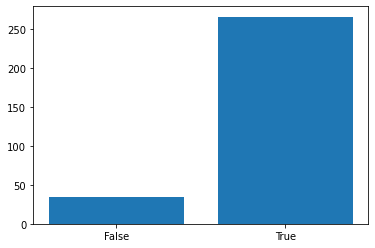

In [204]:
classification = [1 if abs(x-y)>1 else 0 for x,y in P_vs_T ]
print(Counter(classification))
plt.bar(x = [0,1], height = Counter(classification).values(),tick_label=["False", "True"] )
plt.show()

In [205]:
#輸出模型截距與係數
print(regressor.fit(x_train,y_train).intercept_)
print(regressor.fit(x_train,y_train).coef_)

-44523.24795565677
[-4.07e-05 -1.28e-02 -8.63e+00  4.81e-01  4.45e+02  4.46e+02  4.45e+02
  4.45e+02  4.45e+02  1.20e-02 -4.25e-01  7.47e+00  5.78e-01  2.51e-01]




# 反向淘汰

In [206]:
# 加上常數1以符合回歸模型 y = b0+b1*X+b2*X^2+b3*X^3...
x_train = np.append(arr = np.ones((len(x_train[:,1]),1)).astype(int), values = x_train, axis = 1)

# back elimination
col = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

R_square = []
for i in range(len(col)):
    x_opt=np.array(x_train[:,col], dtype=float)
    regressor_OLS=sm.OLS(endog=y_train, exog= x_opt).fit()
    R_square.append(regressor_OLS.rsquared)
    
    if regressor_OLS.rsquared == max(R_square):
        summary = regressor_OLS.summary()
        attribute = col.copy()
        
    P = regressor_OLS.pvalues.tolist()
    print(col)
    col.pop(P.index(max(P)))

    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
[0, 2, 3, 6, 7, 8, 9, 10, 11, 12]
[2, 3, 6, 7, 8, 9, 10, 11, 12]
[2, 3, 6, 7, 8, 9, 10, 12]
[2, 3, 6, 7, 8, 10, 12]
[3, 6, 7, 8, 10, 12]
[3, 6, 7, 8, 12]
[3, 6, 7, 8]
[3, 7, 8]
[7, 8]
[7]


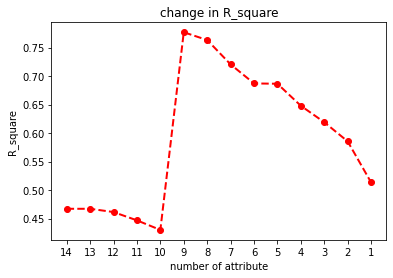

In [207]:

plt.plot(R_square,'ro--', linewidth=2, markersize=6)
plt.xticks(ticks = [i for i in range(0,14)], labels= [i for i in range(1,15)][::-1])

plt.title("change in R_square")
plt.xlabel('number of attribute')
plt.ylabel('R_square')

plt.show()

In [208]:
col_map = dict(zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13], dataset_regression.iloc[:, 3:].columns))

print(attribute)
print(list(map(lambda x:col_map.get(x), attribute)))


[2, 3, 6, 7, 8, 9, 10, 11, 12]
['workage_avg', 'age_avg', 'cpct', 'dpct', 'epct', 'emp_sum', 'emp_age', 'emp_yr', 'rating']


In [209]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.747
Method:                 Least Squares   F-statistic:                              25.55
Date:                Mon, 29 May 2023   Prob (F-statistic):                    2.97e-18
Time:                        16:19:46   Log-Likelihood:                         -257.92
No. Observations:                  75   AIC:                                      533.8
Df Residuals:                      66   BIC:                                      554.7
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0123      0.003     -4.325      0.000      -0.018      -0.007
x2            -8.1053      1.403     -5.778      0.000     -10.906      -5.304
x3             0.5574      0.115      4.868      0.000       0.329       0.786
x4             0.3742      0.090      4.178      0.000       0.195       0.553
x5             0.3651      0.086      4.236      0.000       0.193       0.537
x6             0.4576      0.117      3.914      0.000       0.224       0.691
x7             0.0116      0.003      4.330      0.000       0.006       0.017
x8            -0.4347      0.216     -2.012      0.048      -0.866      -0.003
x9             7.2440      1.451      4.993      0.000       4.347      10.141
==============================================================================
Omnibus:                       45.020   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.690
Skew:                           1.844   Prob(JB):                     7.75e-36
Kurtosis:                       9.175   Cond. No.                     3.77e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [210]:
chi_name = ["離職人數", "員工人數", "員工平均年資", "員工平均年齡", "博士%", "碩士%", "大專%", "高中%", "高中以下%", "合計人數", "平均年齡", "平均年資", "等級", "違反勞動基準法次數"]
for i, j in zip(col_map.values(), chi_name):
    print(f"{i} : {j}")
    

num_resign : 離職人數
num_staff : 員工人數
workage_avg : 員工平均年資
age_avg : 員工平均年齡
apct : 博士%
bpct : 碩士%
cpct : 大專%
dpct : 高中%
epct : 高中以下%
emp_sum : 合計人數
emp_age : 平均年齡
emp_yr : 平均年資
rating : 等級
violate_times : 違反勞動基準法次數
